In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import tensorflow as tf
import pathlib
import os
import shutil
import random
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
current_path = os.getcwd() # get the path of this current file
print(current_path)
image_path = current_path.removesuffix("OmniModel") + "\\animals\\in use" # prefix it to the path of the images
image_dir = pathlib.Path(image_path).with_suffix('') # get that path as a diretory.
print(image_dir.absolute())

c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel
c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\animals\in use


In [48]:
import PIL.Image

image_count = len(list(image_dir.glob("*/*"))) #
print(image_count)
group_alinement = {
    "tiger":"GroupA",
    "cheetah":"GroupF",
    "lion":"GroupA",
    "cat":"GroupA",
    "bear":"GroupB",
    "dog":"GroupB",
    "cattle":"GroupC",
    "camel":"GroupF",
    "zebra":"GroupC",
    "bird":"GroupD",
    "butterfly":"GroupD",
    "caterpillar":"GroupD",
    "snake":"GroupE",
    "crocodile":"GroupE",
    "crab":"GroupE",
}
animal_group_imgs = {"GroupA":{},"GroupB":{},"GroupC":{},"GroupD":{},"GroupE":{}, "GroupF":{}}

for animal in list(image_dir.iterdir()):
    animal_count = len(list(animal.glob("*")))
    animal_name = animal.name
    animal_group_imgs[group_alinement[animal_name.lower()]][animal_name] = list(animal.glob("*.jpg")) + list(animal.glob("*.jpeg")) + list(animal.glob("*.png"))
    
    print(f"Number of {animal_name} is {animal_count}, {animal_count - len(animal_group_imgs[group_alinement[animal_name.lower()]][animal_name])} not stored")
    print(f"{animal_name} sent to grouping {group_alinement[animal_name.lower()]}.\n")

16310
Number of bear is 252, 0 not stored
bear sent to grouping GroupB.

Number of bird is 2035, 0 not stored
bird sent to grouping GroupD.

Number of butterfly is 2112, 0 not stored
butterfly sent to grouping GroupD.

Number of camel is 93, 1 not stored
camel sent to grouping GroupF.

Number of cat is 1728, 0 not stored
cat sent to grouping GroupA.

Number of caterpillar is 553, 0 not stored
caterpillar sent to grouping GroupD.

Number of cattle is 1208, 0 not stored
cattle sent to grouping GroupC.

Number of cheetah is 133, 1 not stored
cheetah sent to grouping GroupF.

Number of crab is 365, 0 not stored
crab sent to grouping GroupE.

Number of crocodile is 185, 1 not stored
crocodile sent to grouping GroupE.

Number of dog is 4899, 0 not stored
dog sent to grouping GroupB.

Number of lion is 368, 0 not stored
lion sent to grouping GroupA.

Number of snake is 1775, 0 not stored
snake sent to grouping GroupE.

Number of tiger is 363, 0 not stored
tiger sent to grouping GroupA.

Numbe

In [49]:
# now that we have the groups and the animals in each group. we need to pic randomly from each group 
# to make the training data.

data_capacity = 100
test_ratio = 0.1

print("With the current data cap, the aprox size of the data is", data_capacity * len(animal_group_imgs.keys()))

training_folder_path = current_path + "\\MainModel\\Training"

os.makedirs(training_folder_path,exist_ok=True)
training_dir = pathlib.Path(training_folder_path).with_suffix('')

for group_name, animal_group in animal_group_imgs.items():
    print("Gathering Training Data for",group_name)
    print("Consite of",list(animal_group.keys()))
    
    class_folder = training_folder_path + "\\" + group_name
    os.makedirs(class_folder,exist_ok=True)
    class_dir = pathlib.Path(class_folder).with_suffix('')
    
    class_size = len(list(class_dir.iterdir()))
    print("\tStarting with", class_size)
    available_img_lists = [key for key, lst in animal_group.items() if len(lst) > 0]
    #print("[Debug]",available_img_lists)
    while len(available_img_lists) > 0:
        if class_size > (1-test_ratio)*data_capacity: print("ping!"); break
        
        temp_key = random.choice(available_img_lists)
        temp_index = random.randrange(0,len(animal_group[temp_key]))
        img = animal_group[temp_key].pop(temp_index)
        #print("[Debug]",len(animal_group[temp_key]))
        if len(animal_group[temp_key]) == 0: available_img_lists.remove(temp_key)
        try:
            full_path = str(img.absolute())
            full_path.encode("latin-1")
        except UnicodeEncodeError as e:
            print("Encoding error in file:",full_path,"\n",e)
            os.unlink(full_path)
            continue
        
        shutil.copy2(full_path,str(class_dir.absolute()))
        class_size = len(list(class_dir.iterdir()))
    print("\tEnding with", class_size)
    print()

With the current data cap, the aprox size of the data is 600
Gathering Training Data for GroupA
Consite of ['cat', 'lion', 'tiger']
	Starting with 0
ping!
	Ending with 91

Gathering Training Data for GroupB
Consite of ['bear', 'dog']
	Starting with 0
ping!
	Ending with 91

Gathering Training Data for GroupC
Consite of ['cattle', 'zebra']
	Starting with 0
ping!
	Ending with 91

Gathering Training Data for GroupD
Consite of ['bird', 'butterfly', 'caterpillar']
	Starting with 0
ping!
	Ending with 91

Gathering Training Data for GroupE
Consite of ['crab', 'crocodile', 'snake']
	Starting with 0
ping!
	Ending with 91

Gathering Training Data for GroupF
Consite of ['camel', 'cheetah']
	Starting with 0
ping!
	Ending with 91



In [50]:
testing_folder_path = current_path + "\\MainModel\\Testing"

os.makedirs(testing_folder_path,exist_ok=True)
testing_dir = pathlib.Path(testing_folder_path).with_suffix('')

for group_name, animal_group in animal_group_imgs.items():
    print("Gathering Testing Data for",group_name)
    print("Consite of",list(animal_group.keys()))
    
    group_folder = testing_folder_path + "\\" + group_name
    os.makedirs(group_folder, exist_ok=True)
    if len(animal_group.keys()) == 0: animal_capacity = 0
    else: animal_capacity = (test_ratio)*data_capacity // len(animal_group.keys())

    for animal, img_list in animal_group.items():
        print("\tLooking into",animal)
        class_folder = group_folder + "\\" + animal
        os.makedirs(class_folder, exist_ok=True)
        class_dir = pathlib.Path(class_folder).with_suffix('')
        
        class_size = len(list(class_dir.iterdir()))
        print("\t Started with",class_size)
        
        while len(img_list) > 0:
            if class_size > animal_capacity: print("ping!"); break
            
            temp_index = random.randrange(0,len(img_list))
            img = img_list.pop(temp_index)
            try:
                full_path = str(img.absolute())
                full_path.encode("latin-1")
            except UnicodeEncodeError as e:
                print("Encoding error in file:",full_path,"\n",e)
                os.unlink(full_path)
                continue
            
            shutil.copy2(full_path,str(class_dir.absolute()))
            class_size = len(list(class_dir.iterdir()))
        print("\t Ended with",class_size)
    print()

Gathering Testing Data for GroupA
Consite of ['cat', 'lion', 'tiger']
	Looking into cat
	 Started with 0
ping!
	 Ended with 4
	Looking into lion
	 Started with 0
ping!
	 Ended with 4
	Looking into tiger
	 Started with 0
ping!
	 Ended with 4

Gathering Testing Data for GroupB
Consite of ['bear', 'dog']
	Looking into bear
	 Started with 0
ping!
	 Ended with 6
	Looking into dog
	 Started with 0
ping!
	 Ended with 6

Gathering Testing Data for GroupC
Consite of ['cattle', 'zebra']
	Looking into cattle
	 Started with 0
ping!
	 Ended with 6
	Looking into zebra
	 Started with 0
ping!
	 Ended with 6

Gathering Testing Data for GroupD
Consite of ['bird', 'butterfly', 'caterpillar']
	Looking into bird
	 Started with 0
ping!
	 Ended with 4
	Looking into butterfly
	 Started with 0
ping!
	 Ended with 4
	Looking into caterpillar
	 Started with 0
ping!
	 Ended with 4

Gathering Testing Data for GroupE
Consite of ['crab', 'crocodile', 'snake']
	Looking into crab
	 Started with 0
ping!
	 Ended with 4
	

In [51]:
print("Training Info:")
print("Dir:",training_dir.absolute())
image_count = len(list(training_dir.glob("*/*")))
print(image_count)
for animal in list(training_dir.iterdir()):
    animal_count = len(list(animal.glob("*")))
    animal_name = animal.name
    print(f"Number of {animal_name} is {animal_count}")

print()

print("Testing Info: ")
print("Dir:",testing_dir.absolute())
image_count = len(list(testing_dir.glob("*/*/*")))
print(image_count)
for animal in list(testing_dir.iterdir()):
    animal_count = len(list(animal.glob("*/*")))
    animal_name = animal.name
    print(f"Number of {animal_name} is {animal_count}")

Training Info:
Dir: c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel\MainModel\Training
546
Number of GroupA is 91
Number of GroupB is 91
Number of GroupC is 91
Number of GroupD is 91
Number of GroupE is 91
Number of GroupF is 91

Testing Info: 
Dir: c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel\MainModel\Testing
72
Number of GroupA is 12
Number of GroupB is 12
Number of GroupC is 12
Number of GroupD is 12
Number of GroupE is 12
Number of GroupF is 12


In [52]:
batch_size = 32
img_h = 250
img_w = 250

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_h,img_w),
    batch_size = batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_h,img_w),
    batch_size = batch_size
)

class_names = train_ds.class_names
num_classes = len(list(class_names))
print(num_classes)
print(class_names)

Found 546 files belonging to 6 classes.
Using 437 files for training.
Found 546 files belonging to 6 classes.
Using 109 files for validation.
6
['GroupA', 'GroupB', 'GroupC', 'GroupD', 'GroupE', 'GroupF']


In [53]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
for _ in range(3):
    train_ds = train_ds.cache().shuffle(1000)

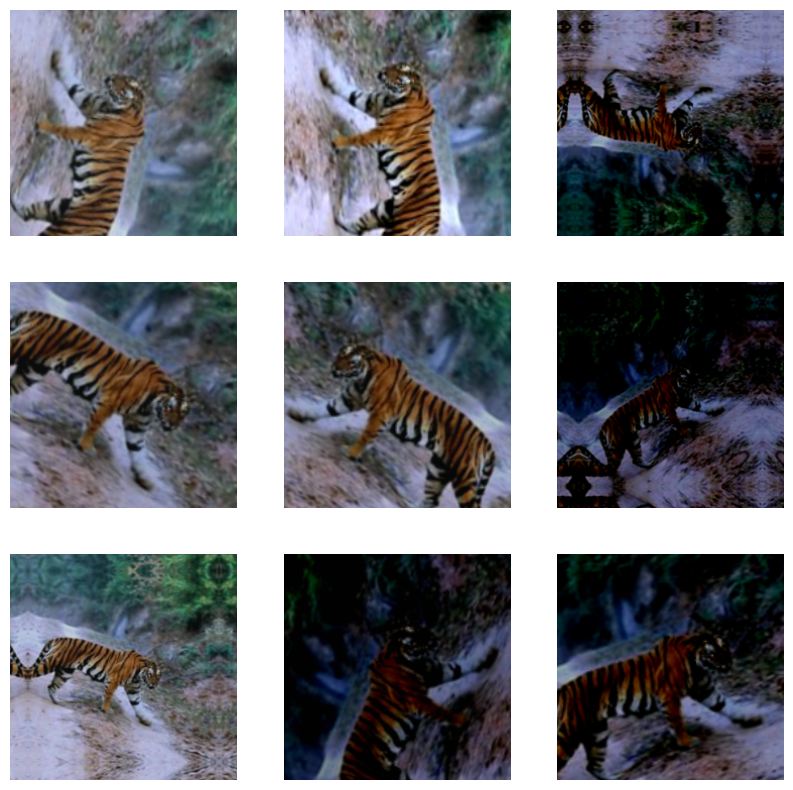

In [55]:
data_agumentor = Sequential([
    # Sharpen(),
    layers.RandomCrop(height=225,width=225,input_shape=(img_h,img_w,3)),
    layers.RandomFlip('horizontal',input_shape=(img_h,img_w,3)),
    layers.RandomBrightness(0.5),
    layers.RandomFlip('vertical',input_shape=(img_h,img_w,3)),
    layers.RandomContrast(0.15),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.3),
])

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        aug_imgs = data_agumentor(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_imgs[0].numpy().astype('uint8'))
        plt.axis("off")

In [60]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
data_agumentor,
  layers.Rescaling(1./255),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.35),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer = Adam(learning_rate=0.00075), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 225, 225, 3)       0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 112, 112, 3)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 56, 56, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 32)       

In [57]:
class StopAtThreshold(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.90):
        super(StopAtThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if current >= self.threshold:
                print(f"\nEpoch {epoch}: Reached {self.monitor} of {current}, stopping training.")
                self.model.stop_training = True

In [58]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
epoch_range = []

In [59]:
from IPython.display import clear_output

loss_stopping = EarlyStopping(monitor='val_loss', patience=7)
hi_acc_stopping = StopAtThreshold(monitor='val_accuracy',threshold=0.9)

slowed_count = 0
regres = False
n = 2
alpha = 0.0005
full_process = False
for i in range(1,n+1):
    clear_output(wait=True)
    
    tf.keras.backend.set_value(model.optimizer.learning_rate, alpha)
    
    print("Phase:",i,"alpha:",float(model.optimizer.learning_rate))
    epochs = 10
    training_record = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs,
        callbacks=[hi_acc_stopping]
    )

    train_acc += training_record.history['accuracy'] # getting training and validation accuracy
    val_acc += training_record.history['val_accuracy']

    train_loss += training_record.history['loss']
    val_loss += training_record.history['val_loss'] # getting training and validation loss

    last_acc = val_acc[-1]
    last_loss = val_loss[-1]
    
    #if len(train_loss)%20 == 0: alpha*= 0.75
    
    loss_diff = 0
    for i in range(epochs): loss_diff += train_loss[-(i+1)]-val_loss[-(i+1)]
    
    if loss_diff < 0.05: print("[WARNING] Learning Slowed!"); slowed_count += 1
    
    gradient = 0 # detecting learning greation. Also happens with overfitting.
    for i in range(0,epochs,2): gradient += (val_acc[i+1] - val_acc[i])/2
    gradient = gradient/(epochs//2)
    if gradient < 0 and regres:
        break
    elif gradient < -0.1: 
        print("[WARNING] Learning Regression!")
        regres = True
    elif gradient > 0:
        regres = False 
    
    if model.stop_training:break

full_process = True
print("Learing Slowed",slowed_count,"time.")

Phase: 1 alpha: 0.0005000000237487257
Epoch 1/10
14/14 [==============================] - 28s 928ms/step - loss: 1.8021 - accuracy: 0.1648 - val_loss: 1.7918 - val_accuracy: 0.1284
Epoch 2/10
14/14 [==============================] - 9s 646ms/step - loss: 1.7919 - accuracy: 0.1716 - val_loss: 1.7919 - val_accuracy: 0.1284
Epoch 3/10
14/14 [==============================] - 9s 641ms/step - loss: 1.7917 - accuracy: 0.1808 - val_loss: 1.7920 - val_accuracy: 0.1284
Epoch 4/10
14/14 [==============================] - 8s 563ms/step - loss: 1.7918 - accuracy: 0.1762 - val_loss: 1.7921 - val_accuracy: 0.1284
Epoch 5/10
14/14 [==============================] - 8s 563ms/step - loss: 1.7917 - accuracy: 0.1762 - val_loss: 1.7921 - val_accuracy: 0.1284
Epoch 6/10
 8/14 [================>.............] - ETA: 2s - loss: 1.7916 - accuracy: 0.1796

KeyboardInterrupt: 

In [17]:
if not full_process:
    train_acc += training_record.history['accuracy'] # getting training and validation accuracy
    val_acc += training_record.history['val_accuracy']

    train_loss += training_record.history['loss']
    val_loss += training_record.history['val_loss'] # getting training and validation loss

In [18]:
import math
def smoothen(lst,sample_rate=0.05):
    if len(lst) == 0: return []
    rlist = []
    area = math.ceil(sample_rate * len(lst))
    for upperbound in range(len(lst)):
        lowerbound = max(0,upperbound-area)
        # print(lowerbound,upperbound)
        sample = lst[lowerbound:upperbound+1].copy()
        sample.sort()
        median = math.ceil(0.5*len(sample))
        rlist.append(sample[median-1])
    return rlist

def gradient(lst,sampling=True,sample_rate=0.25):
    if len(lst)==0:return []
    rlist = []
    area = math.ceil(sample_rate* len(lst))
    if not sampling: area = 2
    for upperbound in range(len(lst)):
        lowerbound = max(0,upperbound - area)
        sample = lst[lowerbound:upperbound+1].copy()
        gradients = [(sample[i+1] - sample[i])/2 for i in range(0,len(sample)-1,2)]
        if len(sample) == 1: gradients = [0]
        gradients.sort()
        mid = math.ceil(0.5 * len(gradients))
        
        rlist.append(gradients[mid - 1])
    return rlist

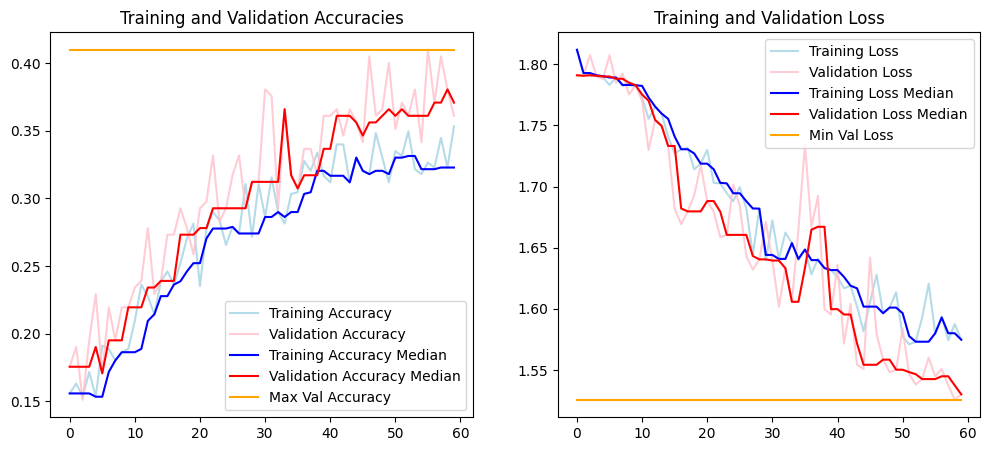

In [43]:
epoch_range = range(len(train_loss)) # getting a range for the epochs to act as a time scale.
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epoch_range,train_acc,color='lightblue',alpha= 0.9,label='Training Accuracy')
plt.plot(epoch_range,val_acc,color='pink',alpha= 0.8,label='Validation Accuracy')
plt.plot(epoch_range,smoothen(train_acc),color='blue',label='Training Accuracy Median')
plt.plot(epoch_range,smoothen(val_acc),color='red',label='Validation Accuracy Median')
plt.plot(epoch_range,[max(val_acc) for _ in range(len(epoch_range))],color='orange',label='Max Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracies')

plt.subplot(1,2,2)
plt.plot(epoch_range,train_loss,color='lightblue',alpha= 0.9,label='Training Loss')
plt.plot(epoch_range,val_loss,color='pink',alpha= 0.8,label='Validation Loss')
plt.plot(epoch_range,smoothen(train_loss),color='blue',label='Training Loss Median')
plt.plot(epoch_range,smoothen(val_loss),color='red',label='Validation Loss Median')
plt.plot(epoch_range,[min(val_loss) for _ in range(len(epoch_range))],color='orange',label='Min Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [45]:
Accuracy = {name:[0.0,{animal:0.0 for animal in group.keys()}] for name,group in animal_group_imgs.items()}
Recall = {name:[0.0,{animal:0.0 for animal in group.keys()}] for name,group in animal_group_imgs.items()}

for group_dir in list(testing_dir.iterdir()):
    right_answer = group_dir.name
    for animal_dir in list(group_dir.iterdir()):
        class_count = 0
        correct_answers = 0
        scores = []
        for img_path in list(animal_dir.iterdir()):
            try:
                img = tf.keras.utils.load_img(
                    img_path, target_size=(img_h, img_w)
                )
            except:
                continue

            class_count += 1
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array,0)

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])
            scores.append(tuple(score.numpy()))
            
            if right_answer == class_names[np.argmax(score)]: correct_answers += 1
        Accuracy[group_dir.name][1][animal_dir.name] = correct_answers/class_count
    if len(Accuracy[group_dir.name][1].keys()) == 0: val = 0
    else: val = sum([Accuracy[group_dir.name][1][name] for name in Accuracy[group_dir.name][1].keys()])/len(Accuracy[group_dir.name][1].keys())
    Accuracy[group_dir.name][0] = val

1/1 [==============================] - 0s 36ms/step


In [46]:
print("Accuracy scores after testing")
for group, pair in Accuracy.items():
    print(f"<{group}> {pair[0]}")
    for name, acc in pair[1].items():
        print(f"\t<{name}> {acc}")
    print()

Accuracy scores after testing
<GroupA> 0.12121212121212122
	<cat> 0.09090909090909091
	<lion> 0.09090909090909091
	<tiger> 0.18181818181818182

<GroupB> 0.28125
	<bear> 0.25
	<dog> 0.3125

<GroupC> 0.65625
	<cattle> 0.5625
	<zebra> 0.75

<GroupD> 0.6666666666666666
	<bird> 0.45454545454545453
	<butterfly> 0.6363636363636364
	<caterpillar> 0.9090909090909091

<GroupE> 0.15151515151515152
	<crab> 0.18181818181818182
	<crocodile> 0.18181818181818182
	<snake> 0.09090909090909091

<GroupF> 0.0625
	<camel> 0.0
	<cheetah> 0.125



In [47]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

saved_file_name = "main_model_v"
version_count = 1
for dir in list(pathlib.Path(current_path + "\\models").glob("*.tflite")):
    if dir.name.startswith(saved_file_name): version_count += 1
saved_file_name += str(version_count)

# Save the model.
with open('models\\'+saved_file_name+".tflite", 'wb') as f:
  f.write(tflite_model)

print("File saved as",saved_file_name)

INFO:tensorflow:Assets written to: C:\Users\ArtBot\AppData\Local\Temp\tmpx27ro9js\assets


INFO:tensorflow:Assets written to: C:\Users\ArtBot\AppData\Local\Temp\tmpx27ro9js\assets


File saved as main_model_v6
